In [23]:
for i in range(0,0):
    print(i)


# 环境配置

In [14]:
# 验证设置是否生效
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"
print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES"))


CUDA_VISIBLE_DEVICES: 2,3


In [ ]:
import os
import torch
from torch import float16
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
from models.Phi_3_5_MoE_instruct.modeling_phimoe import PhiMoEForCausalLM
from models.DeepSeek_V2_Lite.modeling_deepseek import DeepseekV2ForCausalLM 
# 加载模型和分词器
# model_name = "/home/pairshoe/lxm/models/DeepSeek_V2_Lite"
# model_name = "mistralai/Mixtral-8x7B-Instruct-v0.1"
# model_name = "/home/pairshoe/lxm/models/Phi_3_5_MoE_instruct"
model_name = "/home/pairshoe/lxm/models/Qwen1.5_MoE_A2.7B"

config = AutoConfig.from_pretrained(model_name, trust_remote_code=True)
# config.num_experts_per_tok = 2 # Top k 
# print(config)
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True) 
# model = DeepseekV2ForCausalLM.from_pretrained(model_name, trust_remote_code=True,torch_dtype = float16).to("cuda:2")
# model = PhiMoEForCausalLM.from_pretrained(model_name, trust_remote_code=True,config=config,torch_dtype = float16,device_map="auto")
# model = DeepseekV2ForCausalLM.from_pretrained(model_name, trust_remote_code=True,config=config,torch_dtype = float16).to("cuda")
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True,config=config,torch_dtype = float16,device_map="auto")


Loading checkpoint shards: 100%|██████████| 8/8 [00:15<00:00,  1.92s/it]


['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_assisted_decoding', '_auto_class', '_autoset_attn_implementation', '_backward_compatibility_gradient_checkpointing', '_backward_hooks', '_backward_pre_hooks', '_beam_search', '_beam_search_has_unfinished_sequences', '_buffers', '_call_impl', '_check_and_enable_flash_attn_2', '_check_and_enable_flex_attn', '_check_and_enable_sdpa', '_compiled_call_impl', '_constrained_beam_search', '_contrastive_search', '_convert_head_mask_to_5d', '_copy_lm_head_original_to_resized', '_create_repo', '_dispatch_accelerate_model', '_dola_decoding', '_expand_inp

In [16]:

# model.eval()
print(type(model))
print(dir(model))

<class 'transformers.models.qwen2_moe.modeling_qwen2_moe.Qwen2MoeForCausalLM'>
['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_assisted_decoding', '_auto_class', '_autoset_attn_implementation', '_backward_compatibility_gradient_checkpointing', '_backward_hooks', '_backward_pre_hooks', '_beam_search', '_beam_search_has_unfinished_sequences', '_buffers', '_call_impl', '_check_and_enable_flash_attn_2', '_check_and_enable_flex_attn', '_check_and_enable_sdpa', '_compiled_call_impl', '_constrained_beam_search', '_contrastive_search', '_convert_head_mask_to_5d', '_copy_lm_head_original_to_resized

# 函数定义

In [2]:
from collections import defaultdict
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import json
from pathlib import Path


def cosine_similarity_scipy(vec1, vec2):
    # cosine 函数返回的是余弦距离 (1 - 余弦相似度)
    return 1 - cosine(vec1, vec2)

def plot_cosine_similarity_grid(
    frequencies,
    layers=range(0, 32),
    token_start=1,
    token_end=None,
    base_width_per_plot=10,  # 每个子图的基准宽度（英寸）
    base_height_per_plot=10,  # 每个子图的基准高度（英寸）
    max_cols=10,  # 最大列数
    bar_color='lightblue',
    bar_edgecolor='black',
    bar_width=0.8,
    y_ticks=np.arange(0, 1.2, 0.2),
    base_title_fontsize=22,
    base_label_fontsize=20,
    base_tick_fontsize=25,
    output_path=None,
    output_format="svg",
    dpi=600,
    bbox_inches="tight"
):
    """
    Plots a grid of cosine similarity bar charts for a specified range of tokens, with dynamic figure size.

    Parameters:
        frequencies (dict): A nested dictionary containing frequency data.
        layers (iterable): The layers (e.g., layers) to plot on the x-axis.
        token_start (int): Start index of the token range to plot (inclusive).
        token_end (int): End index of the token range to plot (exclusive). If None, defaults to the maximum available tokens.
        base_width_per_plot (float): Base width per subplot in inches.
        base_height_per_plot (float): Base height per subplot in inches.
        max_cols (int): Maximum number of columns in the subplot grid.
        bar_color (str): Color of the bars.
        bar_edgecolor (str): Edge color of the bars.
        bar_width (float): Width of the bars.
        y_ticks (array-like): Y-axis ticks for the plots.
        base_title_fontsize (int): Base font size for subplot titles.
        base_label_fontsize (int): Base font size for axis labels.
        base_tick_fontsize (int): Base font size for tick labels.
        output_path (str): Path to save the output figure.
        output_format (str): Format of the output file (e.g., "svg", "png").
        dpi (int): DPI for the saved figure.
        bbox_inches (str): Bounding box adjustment for saving the figure.
    """
    # 确定 token 范围
    max_tokens = len(frequencies[list(frequencies.keys())[0]]['routed']) - 1
    print(max_tokens)
    token_end = min(token_end or max_tokens, max_tokens)
    token_range = range(token_start, token_end)
    num_plots = len(token_range)

    if num_plots == 0:
        raise ValueError("Token range is empty. Please specify a valid token_start and token_end.")

    # 计算余弦相似度
    all_vec_res = []
    for j in token_range:
        vec_res = []
        for i in layers:
            similarity = cosine_similarity_scipy(frequencies[i]['routed'][j], frequencies[i]['routed'][j + 1])
            vec_res.append(float(similarity))
        all_vec_res.append(vec_res)

    # 动态计算 nrows 和 ncols
    ncols = min(max_cols, num_plots)  # 列数不超过 max_cols
    nrows = (num_plots + ncols - 1) // ncols  # 向上取整计算行数

    # 动态调整 figsize
    width = ncols * base_width_per_plot
    height = nrows * base_height_per_plot
    figsize = (width, height)

    # 动态调整字体大小（根据图片大小缩放）
    scale_factor = min(width / 40, height / 36)  # 基于原始默认 figsize=(40, 36) 的缩放比例
    title_fontsize = base_title_fontsize 
    label_fontsize = base_label_fontsize 
    tick_fontsize = base_tick_fontsize 

    # 创建子图
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharey=True)
    if num_plots > 1:
        axes = axes.flatten()
    else:
        axes = [axes]  # 处理单个子图的情况

    # 绘制每个 token 对的柱状图
    for idx, j in enumerate(token_range):
        ax = axes[idx]
        vec_res = all_vec_res[idx]
        ax.bar(layers, vec_res, color=bar_color, edgecolor=bar_edgecolor, width=bar_width)
        ax.set_title(f'Token{j} & Token{j+1}', fontsize=title_fontsize, pad=10)
        ax.set_xlabel("Layer#", fontsize=label_fontsize)
        ax.set_ylim(0, 1.1)
        ax.set_yticks(y_ticks)
        ax.tick_params(axis='x', labelsize=tick_fontsize)
        ax.tick_params(axis='y', labelsize=tick_fontsize)

    # 关闭未使用的子图
    for j in range(num_plots, nrows * ncols):
        axes[j].axis('off')

    # 调整布局
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.4)
    if output_path is not None:
        plt.savefig(output_path, format=output_format, dpi=dpi, bbox_inches=bbox_inches)
    plt.show()



def plot_cosine_similarity_avg(
    frequencies,
    layers=range(0, 32),
    token_start=0,
    token_end=None,
    base_width_per_plot=10,  # 单个图的基准宽度（英寸）
    base_height_per_plot=6,  # 单个图的基准高度（英寸）
    line_color='red',
    line_style='-',
    marker='o',
    y_ticks=np.arange(0, 1.2, 0.2),
    base_title_fontsize=12,
    base_label_fontsize=10,
    base_tick_fontsize=15,
    output_path=None,
    output_format="svg",
    dpi=600,
    bbox_inches="tight"
):
    """
    Plots a line chart of the average cosine similarity across all token pairs in the specified range, per layer.

    Parameters:
        frequencies (dict): A nested dictionary containing frequency data.
        layers (iterable): The layers (e.g., layers) to plot on the x-axis.
        token_start (int): Start index of the token range to compute (inclusive).
        token_end (int): End index of the token range to compute (exclusive). If None, defaults to the maximum available tokens.
        base_width_per_plot (float): Base width of the plot in inches.
        base_height_per_plot (float): Base height of the plot in inches.
        line_color (str): Color of the line.
        line_style (str): Line style (e.g., '-', '--', '-.', ':').
        marker (str): Marker style for data points (e.g., 'o', 's', '^').
        y_ticks (array-like): Y-axis ticks for the plot.
        base_title_fontsize (int): Font size for the plot title.
        base_label_fontsize (int): Font size for axis labels.
        base_tick_fontsize (int): Font size for tick labels.
        output_path (str): Path to save the output figure and JSON file.
        output_format (str): Format of the output file (e.g., "svg", "png").
        dpi (int): DPI for the saved figure.
        bbox_inches (str): Bounding box adjustment for saving the figure.
    """
    # 确定 token 范围
    max_tokens = len(frequencies[list(frequencies.keys())[0]]['routed']) - 1
    token_end = min(token_end or max_tokens, max_tokens)
    token_range = range(token_start, token_end)
    num_pairs = len(token_range)

    if num_pairs == 0:
        raise ValueError("Token range is empty. Please specify a valid token_start and token_end.")

    # 计算每一层的余弦相似度
    layer_similarities = np.zeros(len(layers))  # 存储每一层的平均相似度
    for j in token_range:
        for idx, i in enumerate(layers):
            similarity = cosine_similarity_scipy(frequencies[i]['routed'][j], frequencies[i]['routed'][j + 1])
            layer_similarities[idx] += similarity
    
    # 计算平均值
    layer_similarities /= num_pairs

    # 设置图形大小
    figsize = (base_width_per_plot, base_height_per_plot)

    # 创建图形
    fig, ax = plt.subplots(figsize=figsize)

    # 绘制折线图
    ax.plot(layers, layer_similarities, color=line_color, linestyle=line_style, marker=marker, label="Average Similarity")

    # 设置标题和标签
    ax.set_title(f'Average Cosine Similarity', fontsize=base_title_fontsize, pad=10)
    ax.set_xlabel("Layer#", fontsize=base_label_fontsize)
    ax.set_ylabel("Average Cosine Similarity", fontsize=base_label_fontsize)

    # 设置刻度
    ax.set_ylim(0, 1.1)
    ax.set_yticks(y_ticks)
    ax.set_xticks(list(layers))
    ax.tick_params(axis='x', labelsize=base_tick_fontsize)
    ax.tick_params(axis='y', labelsize=base_tick_fontsize)

    # 添加图例
    ax.legend(fontsize=base_label_fontsize)

    # 调整布局
    plt.tight_layout()

    # 保存图形和数据
    if output_path is not None:
        # 确保输出路径存在
        output_dir = Path(output_path).parent
        output_dir.mkdir(parents=True, exist_ok=True)

        # 保存图形
        plt.savefig(output_path, format=output_format, dpi=dpi, bbox_inches=bbox_inches)

        # 构造 JSON 文件路径
        json_path = output_path.with_suffix('.json') if isinstance(output_path, Path) else Path(output_path).with_suffix('.json')

        # 保存 layer_similarities 数据为 JSON 文件
        with open(json_path, 'w') as f:
            json.dump({
                "layers": list(layers),
                "similarities": layer_similarities.tolist()
            }, f, indent=4)

    plt.show()
    return layer_similarities


def draw(frequencies,title,save=False):
    # 假设 frequencies 是通过 model.get_all_expert_frequencies() 获取的
    # 确定 MoE 层数和专家数量
    num_moe_layers = len([layer_idx for layer_idx in frequencies.keys() if layer_idx != 0])  # 排除第 0 层
    num_routed_experts = 64  # DeepSeekV2-Lite 有 64 个路由专家

    # 创建激活概率矩阵
    activation_matrix = np.zeros((num_moe_layers, num_routed_experts))

    # 填充矩阵
    layer_counter = 0
    for layer_idx in sorted(frequencies.keys()):
        if layer_idx == 0:  # 跳过第 0 层（非 MoE 层）
            continue
        for expert_idx in range(num_routed_experts):
            activation_matrix[layer_counter, expert_idx] = frequencies[layer_idx]["routed"][expert_idx]
        layer_counter += 1
    print(activation_matrix.sum(axis=-1))
    # 设置绘图风格
    sns.set(style="whitegrid")

    # 创建热力图
    plt.figure(figsize=(15, 10))  # 设置图形大小
    ax = sns.heatmap(
        activation_matrix,
        cmap="OrRd",  # 颜色映射：黄色到红色，值越大颜色越深
        annot=False,    # 不显示格子上的数值（格子太多会显得拥挤）
        fmt=".4f",      # 数值格式（如果 annot=True）
        # cbar_kws={'label': 'Activation Probability'},  # 颜色条标签
        vmin=0, 
        vmax=0.7,
        # annot=True,
        linewidths=.5
    )

    ax.invert_yaxis()

    # 设置标题和轴标签
    plt.title(title, fontsize=16)
    plt.xlabel("Expert Index", fontsize=18)
    plt.ylabel("Layer Index", fontsize=18)
    if save:
        plt.savefig(f'/home/pairshoe/lxm/results/figures/plot.svg', format="svg", dpi=600)
    # 显示图形
    plt.show()
    
    
def draw1(frequencies,save=False):
    # 假设 frequencies 是通过 model.get_all_expert_frequencies() 获取的
    

    # 确定 MoE 层数和专家数量
    num_moe_layers = len([layer_idx for layer_idx in frequencies.keys() if layer_idx != 0])  # 排除第 0 层
    num_routed_experts = 64  # DeepSeekV2-Lite 有 64 个路由专家

    # 创建激活概率矩阵
    activation_matrix = np.zeros((num_moe_layers, num_routed_experts))

    # 填充矩阵
    layer_counter = 0
    for layer_idx in sorted(frequencies.keys()):
        if layer_idx == 0:  # 跳过第 0 层（非 MoE 层）
            continue
        for expert_idx in range(num_routed_experts):
            activation_matrix[layer_counter, expert_idx] = frequencies[layer_idx][expert_idx]
        layer_counter += 1

    # 设置绘图风格
    sns.set(style="whitegrid")

    # 创建热力图
    plt.figure(figsize=(15, 10))  # 设置图形大小
    ax = sns.heatmap(
        activation_matrix,
        cmap="OrRd",  # 颜色映射：黄色到红色，值越大颜色越深
        annot=False,    # 不显示格子上的数值（格子太多会显得拥挤）
        fmt=".4f",      # 数值格式（如果 annot=True）
        # cbar_kws={'label': 'Percentage'},  # 颜色条标签
        # vmin=0,  
        # vmax=1,
        # annot=True,
        linewidths=.5
    )

    ax.invert_yaxis()

    # 设置标题和轴标签
    plt.title(f'Sentence Level', fontsize=16)
    plt.xlabel("Expert Index", fontsize=12)
    plt.ylabel("Layer Index", fontsize=12)
    if save:
        plt.savefig(f'/mnt/petrelfs/liuxinmin/moe/MoE-Infinity/moe_infinity/results/plot.svg', format="svg", dpi=300)
    # 显示图形
    plt.show()
    
# 定义一个递归函数，将 defaultdict 转换为普通字典
def convert_to_dict(nested_defaultdict):
    if isinstance(nested_defaultdict, defaultdict):
        # 递归处理每一层
        return {key: convert_to_dict(value) for key, value in nested_defaultdict.items()}
    else:
        # 如果不是 defaultdict，则直接返回值
        return nested_defaultdict



# 定义一个函数来执行相邻 text_idx 的与运算
def compute_adjacent_and(all_frequencies_dict):
    adjacent_and_results = {}

    # 获取所有 text_idx 并排序
    text_indices = sorted(all_frequencies_dict.keys())

    # 遍历相邻的 text_idx 对
    for i in range(len(text_indices) - 1):
        text_idx_1 = text_indices[i]
        text_idx_2 = text_indices[i + 1]

        # 初始化当前相邻对的结果
        adjacent_and_results[f"{text_idx_1}-{text_idx_2}"] = {}

        # 获取两个相邻 text_idx 的数据
        data_1 = all_frequencies_dict[text_idx_1]
        data_2 = all_frequencies_dict[text_idx_2]

        # 遍历每一层 layer_idx
        for layer_idx in set(data_1.keys()).union(data_2.keys()):
            experts_1 = data_1.get(layer_idx, {})
            experts_2 = data_2.get(layer_idx, {})

            # 对该层的所有 expert_idx 执行与运算
            adjacent_and_results[f"{text_idx_1}-{text_idx_2}"][layer_idx] = {
                expert_idx: experts_1.get(expert_idx, 0) & experts_2.get(expert_idx, 0)
                for expert_idx in set(experts_1.keys()).union(experts_2.keys())
            }

    return adjacent_and_results

In [13]:
import os
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
from datasets import load_dataset
import re
import random

ds = load_dataset("BelleGroup/multiturn_chat_0.8M")

all_texts=[]
# 假设 ds['train'] 是一个数据集，len(ds['train']) 是其长度
random_numbers = random.sample(range(len(ds['train'])), 50)

for i in random_numbers:
    test_data = ds['train'][i]['instruction']
    # 使用正则表达式提取前两条 Human: 后的内容
    human_pattern = r"Human:(.*?)(?=\nAssistant:|\nHuman:|$)"
    matches = re.findall(human_pattern, test_data, re.DOTALL)
    if len(matches) >= 2:
        all_texts.append([matches[0].strip()])
        all_texts.append([matches[1].strip()])


KeyboardInterrupt: 

# 推理

In [3]:
import torch
all_texts=[["Compose a technical article on artificial intelligence."]]
# random_numbers = [random.randint(0, len(dataset)) for _ in range(50)]
# print(random_numbers)
# texts = dataset[random_numbers]["text"]  # 取前 100 个样本进行测试
model.reset_all_expert_counts()
model.reset_all_expert_continue()
model.reset_all_expert_hit_rate()
model.reset_all_token_frequency()

# all_frequencies = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: {})))
for idx,texts in enumerate(all_texts):
# texts = ["帮我生成一句有关夏天的英文名言。","再来一句关于阳光的英文名言。"]
# 重置计数器 
    model.reset_all_expert_counts()
    model.reset_all_expert_continue()
    model.reset_all_expert_hit_rate()
    model.reset_all_token_frequency()

    # # 对数据集进行推理
    for text_idx, text in enumerate(texts):
        if not text.strip():  # 跳过空文本
            continue
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
        input_ids = inputs["input_ids"].to("cuda")
        print(input_ids[0].shape)
        # attention_mask = inputs["attention_mask"].to("cuda")
        # position_ids = torch.arange(input_ids.size(1), dtype=torch.long, device=input_ids.device).unsqueeze(0)

        with torch.no_grad():
            # outputs = model(input_ids, attention_mask=attention_mask, position_ids=position_ids)
            outputs = model.generate(input_ids, max_length=512)
            print(outputs.shape)
            # print(outputs[0])
            output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            print(output_text)
            
        # frequencies = model.get_all_expert_frequencies()
        
        # for layer_idx, layer_frequencies in frequencies.items():
        #     routed_frequencies = layer_frequencies.get("routed", {})
        #     for expert_idx, freq in routed_frequencies.items():
        #         state = 1 if freq >= 0.5 else 0  # 根据条件生成标记
        #         all_frequencies[text_idx][layer_idx][expert_idx] = state
        
        # draw(frequencies)
        # model.reset_all_expert_counts()
# frequencies1 = model.get_all_expert_frequencies()
# frequencies2 = model.get_all_expert_continue()
# frequencies3 = model.get_all_expert_hit_rate()
frequencies3 = model.get_all_token_frequency()
# draw(frequencies1,"Request Level")      
# draw(frequencies,"Token Level")      
        
    # # 将 all_frequencies 转换为普通字典
    # all_frequencies_dict = convert_to_dict(all_frequencies)

    # # 调用函数计算相邻 text_idx 的与运算结果
    # adjacent_and_results = compute_adjacent_and(all_frequencies_dict)
    # for id in adjacent_and_results.keys():
    #     draw1(adjacent_and_results[id])


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.


torch.Size([10])
torch.Size([1, 512])
Compose a technical article on artificial intelligence.
The article should be 1000 words long and include the following:
- An introduction to artificial intelligence.
- A discussion of the different types of artificial intelligence.
- A description of the benefits and drawbacks of artificial intelligence.
- A conclusion.
Artificial intelligence (AI) is a branch of computer science that deals with the creation of intelligent machines that can think and learn like humans. AI is a broad field that encompasses many different subfields, including machine learning, natural language processing, and robotics.
There are many different types of AI, each with its own unique benefits and drawbacks. Some of the most common types of AI include:
- Machine learning: Machine learning is a type of AI that allows computers to learn from data without being explicitly programmed. This allows machines to improve their performance over time without human intervention.
- 

# 数据分析

## 相似度分析

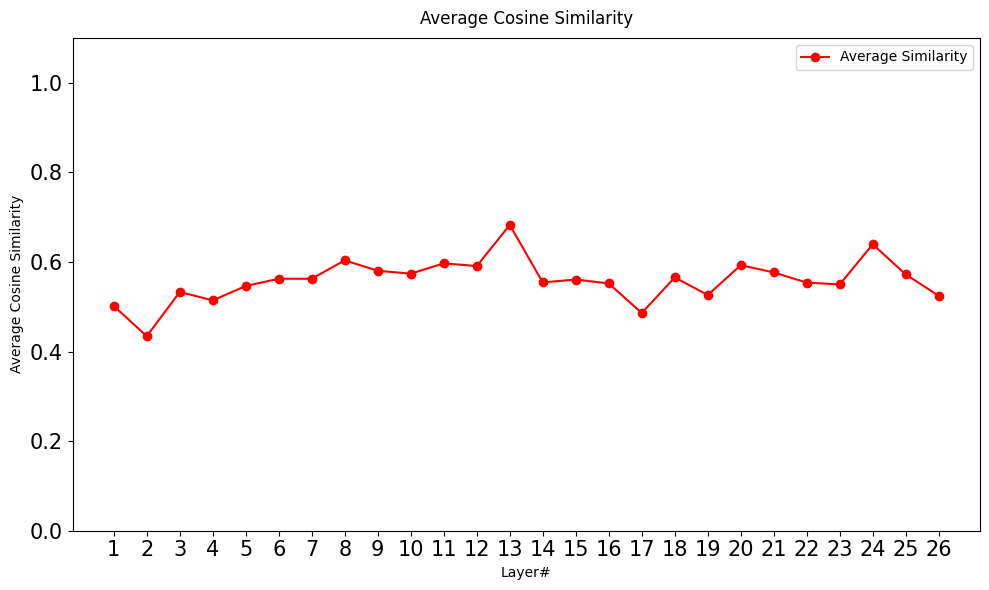

In [8]:
# plot_cosine_similarity_grid(frequencies3,layers=range(0,32),token_start=1,token_end=1,max_cols=5)
res = plot_cosine_similarity_avg(frequencies3,layers=range(1,27),token_start=1,token_end=512,output_path="/home/pairshoe/lxm/results/figures/deepseek/deepseek_simi_avg.svg")